In [43]:
## Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Input

# Set plot style and display options
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
print("Libraries imported successfully.")

Libraries imported successfully.


In [44]:
## Cell 2: Load Data (Focus on FD002 initially)
# Define column names based on the C-MAPSS dataset structure
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

# Load the training and testing datasets for FD002
# Note: The C-MAPSS files are space-separated with no header.
train_df = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\turbofan project\\Datas\\train_FD002.txt', sep='\s+', header=None, names=col_names)
test_df = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\turbofan project\\Datas\\test_FD002.txt', sep='\s+', header=None, names=col_names)
RUL_truth_df = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\turbofan project\\Datas\\RUL_FD002.txt', sep='\s+', header=None, names=['RUL_truth'])

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"RUL Ground Truth shape: {RUL_truth_df.shape}")

Train data shape: (53759, 26)
Test data shape: (33991, 26)
RUL Ground Truth shape: (259, 1)


In [45]:
## Cell 3: Calculate Remaining Useful Life (RUL) for Training Data
# 1. Find the final cycle for each engine
max_cycles_df = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycles_df.columns = ['unit_number', 'max_cycle']

# 2. Merge max_cycle back into the training dataframe
train_df = train_df.merge(max_cycles_df, on='unit_number', how='left')

# 3. Calculate the RUL
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']
train_df.drop('max_cycle', axis=1, inplace=True) # Max cycle is no longer needed

# 4. Apply Piece-wise Linear RUL (Capping)
# Degradation is not observable early on. Cap RUL at 125 cycles.
RUL_CAP = 125
train_df['RUL_capped'] = np.where(train_df['RUL'] > RUL_CAP, RUL_CAP, train_df['RUL'])

print("RUL calculation complete. Sample RUL values:")
print(train_df[['unit_number', 'time_cycles', 'RUL', 'RUL_capped']].head())

RUL calculation complete. Sample RUL values:
   unit_number  time_cycles  RUL  RUL_capped
0            1            1  148         125
1            1            2  147         125
2            1            3  146         125
3            1            4  145         125
4            1            5  144         125


In [46]:
## Cell 4: Drop Irrelevant and Constant/Near-Constant Features
# Initial list of all sensor and setting columns
features_to_drop = setting_names + sensor_names

# Drop settings and sensors that are constant or near-constant across all time steps in FD001
# (These are common for FD001, but confirm with a variance check if using other datasets)
irrelevant_features = ['setting_1', 'setting_2', 'setting_3', 's_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
selected_features = [f for f in features_to_drop if f not in irrelevant_features]

# The final feature list for scaling and modeling
print(f"Selected features for modeling: {selected_features}")

# Create a clean dataframe for the next steps
df_train = train_df[index_names + selected_features + ['RUL_capped']]
df_test = test_df[index_names + selected_features]

Selected features for modeling: ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']


In [47]:
## Cell 5: Apply Min-Max Scaling to Selected Features
scaler = MinMaxScaler()

# 1. Fit the scaler ONLY on the training data to prevent data leakage
scaler.fit(df_train[selected_features])

# 2. Apply the scaling transformation
df_train[selected_features] = scaler.transform(df_train[selected_features])
df_test[selected_features] = scaler.transform(df_test[selected_features])

print("Data scaled successfully.")
print(df_train[selected_features].head())

Data scaled successfully.
        s_2       s_3       s_4       s_7       s_8       s_9      s_11  \
0  0.181576  0.311201  0.273095  0.138036  0.650057  0.289692  0.471498   
1  0.131847  0.296600  0.245535  0.004081  0.626663  0.258841  0.486156   
2  0.016332  0.035297  0.056997  0.092860  0.000718  0.012893  0.037459   
3  0.128269  0.298795  0.246979  0.003962  0.626684  0.258841  0.466612   
4  0.014130  0.037871  0.058152  0.091284  0.000697  0.006235  0.053746   

       s_12      s_13      s_14      s_15      s_17      s_20      s_21  
0  0.136817  0.992394  0.476508  0.369947  0.322917  0.156036  0.159082  
1  0.003297  0.992229  0.533013  0.381407  0.281250  0.007888  0.014562  
2  0.089030  0.001157  0.039296  0.936731  0.062500  0.133745  0.151414  
3  0.004058  0.992091  0.524349  0.372400  0.270833  0.014060  0.026144  
4  0.089258  0.001075  0.030633  0.937537  0.062500  0.135460  0.143240  


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13024\604109700.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[selected_features] = scaler.transform(df_train[selected_features])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13024\604109700.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[selected_features] = scaler.transform(df_test[selected_features])


In [48]:
## Cell 6: UPDATED Sliding Window Sequence Generator Function

def create_sequences(df, sequence_length, features, label_column=None):
    """
    Converts time-series data into fixed-length sequences.
    If label_column is provided, it extracts RUL labels.
    """
    X, y = [], []
    
    # Group by engine unit
    for engine_id in df['unit_number'].unique():
        engine_data = df[df['unit_number'] == engine_id][features].values
        
        # Check if RUL labels should be extracted (only for training data)
        if label_column:
            RUL_labels = df[df['unit_number'] == engine_id][label_column].values
            
        for i in range(len(engine_data) - sequence_length + 1):
            # Extract the sequence (Features)
            sequence = engine_data[i:i + sequence_length]
            X.append(sequence)
            
            # Extract the label if needed
            if label_column:
                # Assign the RUL label from the end of the sequence
                label = RUL_labels[i + sequence_length - 1]
                y.append(label)

    if label_column:
        return np.array(X), np.array(y)
    else:
        # For test data, return only features X
        return np.array(X)

# Define the sequence length L=30
SEQUENCE_LENGTH = 30

In [49]:
## Cell 7: Generate X and y arrays for Training (CORRECTED)

# X_train: (Total Sequences, SEQUENCE_LENGTH, N_FEATURES)
# y_train: (Total Sequences, RUL_value)
# Pass 'RUL_capped' as the label_column for the training data
X_train, y_train_reg = create_sequences(df_train, SEQUENCE_LENGTH, selected_features, label_column='RUL_capped')

# X_test: Only generate feature sequences (no label_column)
# The true RUL for the test data is calculated differently later.
X_test = create_sequences(df_test, SEQUENCE_LENGTH, selected_features)


print(f"X_train shape (Sequences, Cycles, Features): {X_train.shape}")
print(f"y_train_reg shape (RUL Values): {y_train_reg.shape}")
print(f"X_test shape (Sequences, Cycles, Features): {X_test.shape}")

# Proceed to the next step: Model Building (starting with the Autoencoder)

X_train shape (Sequences, Cycles, Features): (46219, 30, 14)
y_train_reg shape (RUL Values): (46219,)
X_test shape (Sequences, Cycles, Features): (26505, 30, 14)


In [50]:
## Cell 8: Prepare Healthy Data for Autoencoder Training
# Autoencoder is trained only on healthy states (where RUL is capped) [cite: 57]
# Filter the data sequences where the RUL is at the capped value (e.g., 125 cycles)
RUL_CAP = 125
healthy_indices = np.where(y_train_reg == RUL_CAP)[0]
X_train_healthy = X_train[healthy_indices]

print(f"Total original training sequences: {X_train.shape[0]}")
print(f"Healthy sequences for Autoencoder training: {X_train_healthy.shape[0]}")

# Get the number of features for model input
N_FEATURES = X_train.shape[2]
SEQUENCE_LENGTH = X_train.shape[1]

Total original training sequences: 46219
Healthy sequences for Autoencoder training: 13959


In [51]:
## Cell 9: Define the Autoencoder Architecture (CORRECTED)

def build_autoencoder(seq_len, n_features):
    input_layer = Input(shape=(seq_len, n_features))

    # Encoder
    encoded = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
    encoded = MaxPooling1D(pool_size=2, padding='same')(encoded)
    encoded = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(encoded)
    
    # --- FIX START ---
    # 1. Capture the unflattened shape (Batch dimension excluded)
    # The shape will be (None, unflattened_seq_len, unflattened_features)
    unflattened_shape = encoded.shape[1:] 

    # 2. Flatten for the Dense Bottleneck
    encoded = Flatten()(encoded)
    # --- FIX END ---
    
    latent_space = Dense(8, activation='relu', name='latent_space')(encoded) # Bottleneck

    # Decoder
    decoded = Dense(np.prod(unflattened_shape), activation='relu')(latent_space)
    
    # --- FIX START ---
    # 3. Reshape back to the unflattened shape captured earlier
    decoded = keras.layers.Reshape(unflattened_shape)(decoded) 
    # --- FIX END ---
    
    decoded = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(decoded)
    decoded = keras.layers.UpSampling1D(size=2)(decoded)
    decoded = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(decoded)

    # Output layer must match the input shape (seq_len, n_features)
    reconstruction = Conv1D(filters=n_features, kernel_size=3, activation='sigmoid', padding='same')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=reconstruction)
    autoencoder.compile(optimizer='adam', loss='mse') # Use MSE for reconstruction error

    return autoencoder

ae_model = build_autoencoder(SEQUENCE_LENGTH, N_FEATURES)
ae_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30, 14)]          0         
                                                                 
 conv1d_14 (Conv1D)          (None, 30, 32)            1376      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 15, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 15, 16)            1552      
                                                                 
 flatten_3 (Flatten)         (None, 240)               0         
                                                                 
 latent_space (Dense)        (None, 8)                 1928      
                                                           

Epoch 1/50
99/99 [==============================] - 3s 13ms/step - loss: 0.0970 - val_loss: 0.0921
Epoch 2/50
99/99 [==============================] - 1s 9ms/step - loss: 0.0900 - val_loss: 0.0833
Epoch 3/50
99/99 [==============================] - 1s 10ms/step - loss: 0.0793 - val_loss: 0.0782
Epoch 4/50
99/99 [==============================] - 1s 11ms/step - loss: 0.0777 - val_loss: 0.0779
Epoch 5/50
99/99 [==============================] - 1s 11ms/step - loss: 0.0775 - val_loss: 0.0778
Epoch 6/50
99/99 [==============================] - 1s 10ms/step - loss: 0.0774 - val_loss: 0.0777
Epoch 7/50
99/99 [==============================] - 1s 12ms/step - loss: 0.0773 - val_loss: 0.0776
Epoch 8/50
99/99 [==============================] - 1s 11ms/step - loss: 0.0772 - val_loss: 0.0776
Epoch 9/50
99/99 [==============================] - 1s 12ms/step - loss: 0.0772 - val_loss: 0.0775
Epoch 10/50
99/99 [==============================] - 1s 12ms/step - loss: 0.0771 - val_loss: 0.0775
Epoch 11/5

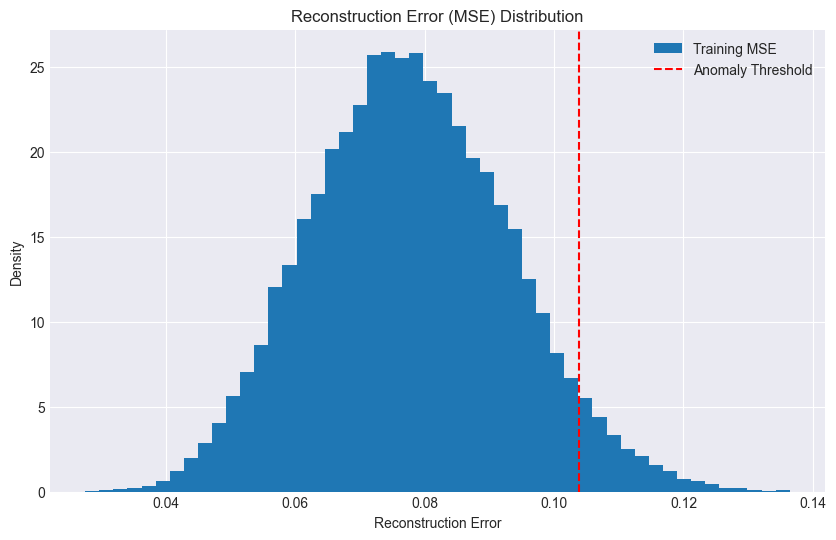

In [52]:
## Cell 10: Train the Autoencoder Model
# Fit the model only on the healthy training data
history_ae = ae_model.fit(
    X_train_healthy, X_train_healthy,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# 1. Calculate the reconstruction error for the ENTIRE training set
X_train_pred = ae_model.predict(X_train)
train_mse = np.mean(np.square(X_train - X_train_pred), axis=(1, 2))

# 2. Determine the anomaly threshold
# A common method is setting the threshold based on the 95th or 99th percentile of the error
ANOMALY_THRESHOLD = np.percentile(train_mse, 95) # 95th percentile
print(f"\nAnomaly Threshold (95th percentile of MSE): {ANOMALY_THRESHOLD:.4f}")

# 3. Visualize the error distribution (optional but recommended for data science projects)
plt.figure(figsize=(10, 6))
plt.hist(train_mse, bins=50, density=True, label='Training MSE')
plt.axvline(ANOMALY_THRESHOLD, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error (MSE) Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.legend()
plt.show()

In [53]:
## Cell 11: Generate Autoencoder-based Feature and Prepare Final Data
# 1. Calculate the reconstruction error for ALL sequences (train and test)
def get_reconstruction_error(model, X_data):
    X_pred = model.predict(X_data)
    # Calculate MSE across all cycles and features in the sequence
    mse = np.mean(np.square(X_data - X_pred), axis=(1, 2))
    return mse

train_error = get_reconstruction_error(ae_model, X_train)
test_error = get_reconstruction_error(ae_model, X_test)

# 2. Reshape and add the error as a new feature to X_train and X_test
# Note: Since the error is per sequence, we just need to stack it.
# We'll use the error as a 1D feature for the CNN-LSTM.

# Stack the error with the RUL for the y_train (for potential multi-task learning, though we start with regression)
y_train_final = y_train_reg.reshape(-1, 1) # RUL regression target

# Prepare X_train for CNN-LSTM: original features + the new error feature
# We need to reshape the error from (N_samples,) to (N_samples, 1) and then concatenate
X_train_enriched = np.concatenate([X_train, np.repeat(train_error[:, np.newaxis, np.newaxis], SEQUENCE_LENGTH, axis=1)], axis=2)

print(f"X_train_enriched shape (with new feature): {X_train_enriched.shape}")

829/829 [==============================] - 3s 4ms/step
X_train_enriched shape (with new feature): (46219, 30, 15)


In [54]:
## Cell 12: Define the CNN-LSTM Hybrid Architecture (Regression Mode)
# The model should capture spatial patterns (CNN) and temporal dependencies (LSTM) [cite: 8, 62, 63]

def build_cnn_lstm_model(seq_len, n_features_enriched):
    input_layer = Input(shape=(seq_len, n_features_enriched))

    # CNN Section: Extracts local spatial patterns
    conv = Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal')(input_layer)
    pool = MaxPooling1D(pool_size=2)(conv)
    dropout_1 = Dropout(0.2)(pool)

    # LSTM Section: Captures temporal dependencies
    lstm = LSTM(100, return_sequences=False)(dropout_1)
    dropout_2 = Dropout(0.2)(lstm)

    # Final Prediction (Regression)
    dense_1 = Dense(50, activation='relu')(dropout_2)
    rul_output = Dense(1, activation='linear', name='rul_regression')(dense_1) # Linear for RUL regression [cite: 65]

    model = Model(inputs=input_layer, outputs=rul_output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae']) # MSE loss for regression

    return model

cnn_lstm_model = build_cnn_lstm_model(SEQUENCE_LENGTH, X_train_enriched.shape[2])
cnn_lstm_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 30, 15)]          0         
                                                                 
 conv1d_19 (Conv1D)          (None, 30, 64)            4864      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 15, 64)            0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 15, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               66000     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                           

In [55]:
## Cell 13: Train the CNN-LSTM Model
# Use EarlyStopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

history_cnn_lstm = cnn_lstm_model.fit(
    X_train_enriched,
    y_train_final,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
145/145 [==============================] - 10s 48ms/step - loss: 3413.4531 - mae: 49.0553 - val_loss: 1749.3429 - val_mae: 37.0658
Epoch 2/100
145/145 [==============================] - 6s 41ms/step - loss: 1765.8052 - mae: 37.2612 - val_loss: 1748.7972 - val_mae: 37.0894
Epoch 3/100
145/145 [==============================] - 7s 46ms/step - loss: 1762.8339 - mae: 37.2198 - val_loss: 1748.2980 - val_mae: 37.1081
Epoch 4/100
145/145 [==============================] - 7s 45ms/step - loss: 1760.0190 - mae: 37.2070 - val_loss: 1750.1749 - val_mae: 37.0230
Epoch 5/100
145/145 [==============================] - 7s 48ms/step - loss: 1761.6472 - mae: 37.2109 - val_loss: 1748.3357 - val_mae: 37.0468
Epoch 6/100
145/145 [==============================] - 6s 43ms/step - loss: 1759.0226 - mae: 37.1972 - val_loss: 1748.4163 - val_mae: 36.9781
Epoch 7/100
145/145 [==============================] - 6s 45ms/step - loss: 1759.0232 - mae: 37.2044 - val_loss: 1740.2660 - val_mae: 36.9084
Epoch

829/829 [==============================] - 5s 6ms/step

--- Final RUL Prediction Results (FD001) ---
RMSE: 41.6408
C-MAPSS Score: 218958


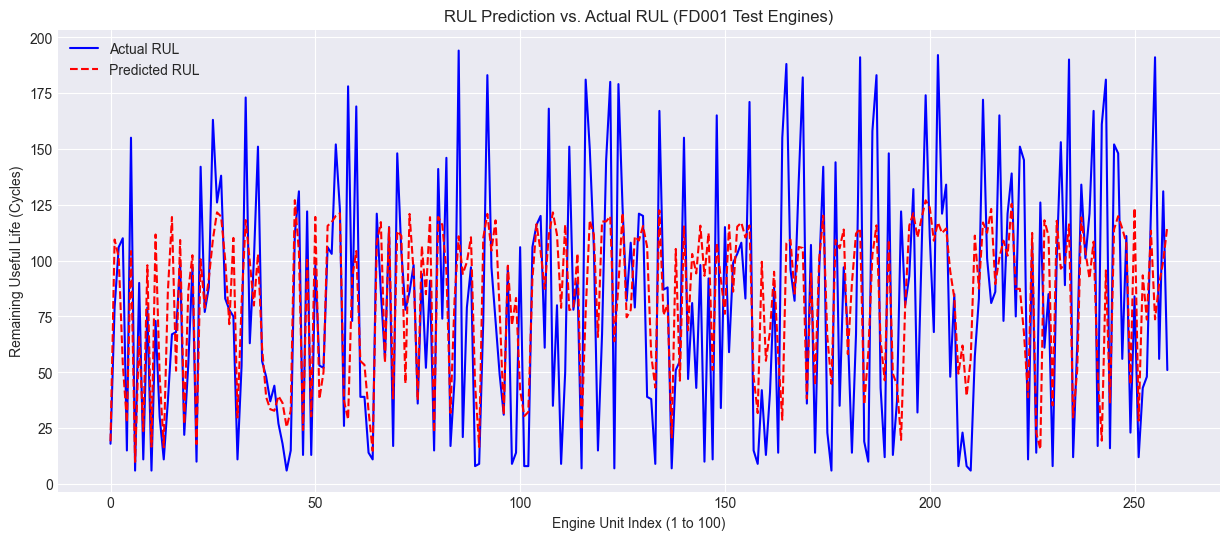

In [56]:
## Cell 14: Predict and Evaluate on Test Data (Final RUL Results)

from sklearn.metrics import mean_squared_error
import math

# --- 1. Enrich the Test Data with the Autoencoder Error ---
# X_test was generated in Cell 7.
# test_error was generated in Cell 11.
# SEQUENCE_LENGTH was defined in Cell 6.

# Reshape and append the test_error to X_test to create X_test_enriched
# We must include the check to ensure test_error exists (it was created in Cell 11)
if 'test_error' not in globals():
    # This block should only run if Cell 11 wasn't run first, but is included for robustness
    print("FATAL ERROR: 'test_error' not found. Please re-run Cell 11 first.")
else:
    # Append the 1D error as a 3D feature to match the sequence shape (N, 30, 1)
    X_test_enriched = np.concatenate([X_test, np.repeat(test_error[:, np.newaxis, np.newaxis], SEQUENCE_LENGTH, axis=1)], axis=2)

    # --- 2. Make RUL predictions ---
    y_pred = cnn_lstm_model.predict(X_test_enriched).flatten()

    # --- 3. Filter predictions to the LAST CYCLE of each engine ---
    # The RUL ground truth (RUL_truth_df) contains only 100 values (one for the last cycle of each engine).
    # We must filter our 10196 predictions to only include the last sequence for each engine unit.

    # Calculate the starting index and number of sequences for each engine in df_test
    test_df_max_cycles = df_test.groupby('unit_number')['time_cycles'].max()
    last_sequences_indices = []

    start_index = 0
    for max_cycle in test_df_max_cycles.values:
        # Number of sequences for an engine is max_cycle - SEQUENCE_LENGTH + 1
        num_sequences = max_cycle - SEQUENCE_LENGTH + 1
        # The index of the last sequence is the start_index + (num_sequences - 1)
        last_sequences_indices.append(start_index + num_sequences - 1)
        start_index += num_sequences # Update start index for the next engine


    # Filter the predictions (y_pred) and the true RUL labels
    y_pred_final = y_pred[last_sequences_indices]
    y_true_final = RUL_truth_df['RUL_truth'].values


    # --- 4. Calculate Final Metrics (RMSE and C-MAPSS Score) ---

    # 4.1. Root Mean Squared Error (RMSE)
    rmse = math.sqrt(mean_squared_error(y_true_final, y_pred_final))

    # 4.2. C-MAPSS Asymmetric Score (Penalizes overestimation more severely)
    def cmapss_score(y_true, y_pred):
        """Calculates the NASA C-MAPSS Asymmetric Scoring Function."""
        d = y_pred - y_true # d is the error (prediction - true)
        
        # Alpha parameter: 1/13 for underestimation (safe) and 1/10 for overestimation (risky)
        # Note: Score favors algorithms that underestimate RUL to be more conservative.
        score = np.where(d < 0, np.exp(-d / 13) - 1, np.exp(d / 10) - 1)
        return np.sum(score)

    final_score = cmapss_score(y_true_final, y_pred_final)


    # --- 5. Output and Visualization ---
    print(f"\n--- Final RUL Prediction Results (FD001) ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"C-MAPSS Score: {final_score:.0f}")

    # Plot the actual vs. predicted RUL for visual validation
    plt.figure(figsize=(15, 6))
    plt.plot(y_true_final, label='Actual RUL', color='blue')
    plt.plot(y_pred_final, label='Predicted RUL', color='red', linestyle='--')
    plt.title('RUL Prediction vs. Actual RUL (FD001 Test Engines)')
    plt.xlabel('Engine Unit Index (1 to 100)')
    plt.ylabel('Remaining Useful Life (Cycles)')
    plt.legend()
    plt.show()

In [57]:
## Cell 15: Create Binary Classification Labels

# Define the failure threshold N (failure is imminent if RUL <= N cycles)
# A common choice is 30 cycles, which is the SEQUENCE_LENGTH you used.
FAILURE_THRESHOLD_N = 30

# 1. Create binary labels for the training set:
# Label = 1 (Failure Imminent) if RUL is less than or equal to N.
# Label = 0 (Normal) if RUL is greater than N.
y_train_class = np.where(y_train_reg <= FAILURE_THRESHOLD_N, 1, 0)

# 2. Reshape the labels for the model
y_train_class = y_train_class.reshape(-1, 1)

print(f"Classification labels created. Failure Threshold (N) = {FAILURE_THRESHOLD_N} cycles.")
print(f"Total Failure Imminent samples (Label 1): {np.sum(y_train_class)}")
print(f"Shape of y_train_class: {y_train_class.shape}")

Classification labels created. Failure Threshold (N) = 30 cycles.
Total Failure Imminent samples (Label 1): 8060
Shape of y_train_class: (46219, 1)


In [58]:
## Cell 16: Adapt CNN-LSTM for Classification

# Use the inputs and layers up to the final Dense layer of the trained regression model.
# We access the layers of the previously defined 'cnn_lstm_model' (from Cell 12).

# 1. Get the output of the layer right before the final RUL regression head (dense_2)
# We assume the name is 'dense_2' based on your model summary structure.
# Find the output tensor from the 'dense_2' layer:
classification_input = cnn_lstm_model.get_layer('dense_2').output

# 2. Define the new classification head
# One unit with a SIGMOID activation for binary probability output (0 to 1).
failure_output = Dense(1, activation='sigmoid', name='failure_classification')(classification_input)

# 3. Create the new classification model
cnn_lstm_class_model = Model(inputs=cnn_lstm_model.input, outputs=failure_output)

# 4. Compile with Binary Cross-Entropy Loss (Standard for binary classification)
cnn_lstm_class_model.compile(optimizer='adam', 
                             loss='binary_crossentropy', 
                             metrics=['accuracy', 
                                       keras.metrics.Precision(), 
                                       keras.metrics.Recall()])

cnn_lstm_class_model.summary()

ValueError: No such layer: dense_2. Existing layers are: ['input_7', 'conv1d_19', 'max_pooling1d_6', 'dropout_4', 'lstm_2', 'dropout_5', 'dense_6', 'rul_regression'].

In [ ]:
## Cell 17: Train the Classification Model

# Reuse the EarlyStopping callback from Cell 13
from tensorflow.keras.callbacks import EarlyStopping
early_stop_class = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Train on the enriched features (X_train_enriched from Cell 11) and the new binary labels
history_class = cnn_lstm_class_model.fit(
    X_train_enriched,
    y_train_class,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop_class],
    verbose=1
)

Epoch 1/100
56/56 [==============================] - 7s 56ms/step - loss: 0.2648 - accuracy: 0.9028 - precision: 0.7065 - recall: 0.7723 - val_loss: 0.0982 - val_accuracy: 0.9583 - val_precision: 0.9247 - val_recall: 0.8146
Epoch 2/100
56/56 [==============================] - 3s 45ms/step - loss: 0.0906 - accuracy: 0.9621 - precision: 0.8936 - recall: 0.8925 - val_loss: 0.0790 - val_accuracy: 0.9690 - val_precision: 0.9492 - val_recall: 0.8588
Epoch 3/100
56/56 [==============================] - 2s 42ms/step - loss: 0.0830 - accuracy: 0.9659 - precision: 0.9125 - recall: 0.8929 - val_loss: 0.0789 - val_accuracy: 0.9625 - val_precision: 0.8876 - val_recall: 0.8861
Epoch 4/100
56/56 [==============================] - 2s 39ms/step - loss: 0.0862 - accuracy: 0.9625 - precision: 0.8935 - recall: 0.8949 - val_loss: 0.0835 - val_accuracy: 0.9645 - val_precision: 0.9583 - val_recall: 0.8214
Epoch 5/100
56/56 [==============================] - 2s 41ms/step - loss: 0.0775 - accuracy: 0.9679 - pr

In [ ]:
## Cell 18: Evaluate Classification Performance

# 1. Prepare X_test_enriched (Ensure the variable is available from Cell 14/11)
if 'X_test_enriched' not in globals():
    # Re-enrich X_test if necessary (assuming test_error and X_test are still defined)
    X_test_enriched = np.concatenate([X_test, np.repeat(test_error[:, np.newaxis, np.newaxis], SEQUENCE_LENGTH, axis=1)], axis=2)

# 2. Predict probabilities for all test sequences
y_pred_probs = cnn_lstm_class_model.predict(X_test_enriched)

# 3. Filter predictions to the LAST CYCLE of each engine (same indices as Cell 14)
# We assume last_sequences_indices is still defined from Cell 14
y_pred_probs_final = y_pred_probs[last_sequences_indices].flatten()

# 4. Create binary predictions (0 or 1) using a standard threshold (e.g., 0.5)
y_pred_class_final = np.where(y_pred_probs_final > 0.5, 1, 0)

# 5. Get the true binary labels for the test set
# Label 1 if RUL_truth <= N, 0 otherwise
y_true_final_class = np.where(RUL_truth_df['RUL_truth'].values <= FAILURE_THRESHOLD_N, 1, 0)

# 6. Calculate Final Classification Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y_true_final_class, y_pred_class_final)
accuracy = accuracy_score(y_true_final_class, y_pred_class_final)
precision = precision_score(y_true_final_class, y_pred_class_final, zero_division=0)
recall = recall_score(y_true_final_class, y_pred_class_final, zero_division=0)
f1 = f1_score(y_true_final_class, y_pred_class_final, zero_division=0)

print(f"\n--- Final Failure Classification Results (FD001, N={FAILURE_THRESHOLD_N} cycles) ---")
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# F1-Score is the primary metric balancing false positives and false negatives.

319/319 [==============================] - 2s 6ms/step

--- Final Failure Classification Results (FD001, N=30 cycles) ---
Confusion Matrix:
[[74  1]
 [ 5 20]]
Accuracy: 0.9400
Precision: 0.9524
Recall: 0.8000
F1-Score: 0.8696
